In this project, we will work with the medical mnist datasource, specifically the pneumonia dataset from https://medmnist.com/ . The problem consists of classifying chest x-ray images as having pneumonia or not. Run the below lines of code to install the appropriate dataloaders and visualize the data

In [ ]:
!pip install -qqq medmnist

     |████████████████████████████████| 87 kB 2.7 MB/s 


In [ ]:
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

*** Challenge 1***

Here the goal is to train on 10 samples on the pneumonia mnist data. In this preliminary testbed, the evaluation will be done on a 1000 sample randomly sampled development set. Note in the end the final evaluation will be done on the full Pneumoniamnist test set as well as potentially a separate dataset. The development set samples here thus should not be used for training in any way, the final evaluation will provide only 10 random samples of the same distribution and as well to evaluate the generality of your algorithm from a data source that is not the Pneumoniamnist training data. 

Feel free to modify this testbed to your liking, including the normalization transformations, etc. Note, however, the final evaluation testbed will have a rigid set of components where you will need to place your answer. The only constraint is the data. Refer to the full project instructions for more information.


Below we set up training functions. Again you are free to fully modify this testbed in your prototyping within the constraints of the data used. You can use tools outside of PyTorch for training models if desired as well although the torchvision dataloaders will still be useful for interacting with the Pneumoniamnist dataset. 

In [ ]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

The below tries 5 random problem instances. Due to the small sample size, the variance of this problem is quite high. Run several instances of the problem to reduce the variance.

Resnet18 + RandAugment + HyperTuned parameters

In [ ]:
def resNet18():
    resNet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    resNet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet18

In [ ]:
%%time
from torchvision.transforms.autoaugment import RandAugment

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

trn_transform = transforms.Compose([transforms.RandAugment(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

val_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=trn_transform, download=download)
val_dataset = DataClass(split='train', transform=val_transform, download=download)

accs_val = []

for seed in  range(0, 50):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(train_dataset, indx_train)
  val_data = Subset(val_dataset, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=32, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=128, 
                                             shuffle=False)

  model = resNet18()
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

  for epoch in range(50):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
  accs_val.append(test(model, device, val_loader))

accs_val = np.array(accs_val)

print('Val acc over 5 instances on dataset: %s %.2f +- %.2f (var: %.2f)'%(data_flag, accs_val.mean(), accs_val.std(), accs_val.var()))

  0%|          | 0/4170669 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


Train Epoch: 0 [0/10 (0%)]	Loss: 0.774668
Train Epoch: 5 [0/10 (0%)]	Loss: 0.945500
Train Epoch: 10 [0/10 (0%)]	Loss: 0.841012
Train Epoch: 15 [0/10 (0%)]	Loss: 0.296508
Train Epoch: 20 [0/10 (0%)]	Loss: 0.028087
Train Epoch: 25 [0/10 (0%)]	Loss: 0.261744
Train Epoch: 30 [0/10 (0%)]	Loss: 0.100989
Train Epoch: 35 [0/10 (0%)]	Loss: 0.011196
Train Epoch: 40 [0/10 (0%)]	Loss: 0.384849
Train Epoch: 45 [0/10 (0%)]	Loss: 0.339588


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 0.3368, Accuracy: 898/1000 (89.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.980454
Train Epoch: 5 [0/10 (0%)]	Loss: 0.905874
Train Epoch: 10 [0/10 (0%)]	Loss: 0.111594
Train Epoch: 15 [0/10 (0%)]	Loss: 0.320252
Train Epoch: 20 [0/10 (0%)]	Loss: 0.394330
Train Epoch: 25 [0/10 (0%)]	Loss: 0.014515
Train Epoch: 30 [0/10 (0%)]	Loss: 0.844372
Train Epoch: 35 [0/10 (0%)]	Loss: 0.030275
Train Epoch: 40 [0/10 (0%)]	Loss: 0.016282
Train Epoch: 45 [0/10 (0%)]	Loss: 0.004704

Val set: Average loss: 0.6792, Accuracy: 801/1000 (80.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.897483
Train Epoch: 5 [0/10 (0%)]	Loss: 0.549157
Train Epoch: 10 [0/10 (0%)]	Loss: 0.057217
Train Epoch: 15 [0/10 (0%)]	Loss: 1.048167
Train Epoch: 20 [0/10 (0%)]	Loss: 0.007768
Train Epoch: 25 [0/10 (0%)]	Loss: 0.022615
Train Epoch: 30 [0/10 (0%)]	Loss: 1.213609
Train Epoch: 35 [0/10 (0%)]	Loss: 0.073654
Train Epoch: 40 [0/10 (0%)]	Loss: 0.145581
Train Epoch: 45 [0/10 (0%)]	Loss: 0.034578

Val set: Average loss: 0.5415, Accuracy: 817/1000 (81.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.578372
Train Epoch: 5 [0/10 (0%)]	Loss: 0.282296
Train Epoch: 10 [0/10 (0%)]	Loss: 1.172422
Train Epoch: 15 [0/10 (0%)]	Loss: 0.301760
Train Epoch: 20 [0/10 (0%)]	Loss: 0.497694
Train Epoch: 25 [0/10 (0%)]	Loss: 0.740173
Train Epoch: 30 [0/10 (0%)]	Loss: 0.287378
Train Epoch: 35 [0/10 (0%)]	Loss: 0.017706
Train Epoch: 40 [0/10 (0%)]	Loss: 0.016963
Train Epoch: 45 [0/10 (0%)]	Loss: 0.022090

Val set: Average loss: 0.9196, Accuracy: 750/1000 (75.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.664946
Train Epoch: 5 [0/10 (0%)]	Loss: 0.522954
Train Epoch: 10 [0/10 (0%)]	Loss: 1.289189
Train Epoch: 15 [0/10 (0%)]	Loss: 0.269481
Train Epoch: 20 [0/10 (0%)]	Loss: 0.485753
Train Epoch: 25 [0/10 (0%)]	Loss: 0.191350
Train Epoch: 30 [0/10 (0%)]	Loss: 0.018848
Train Epoch: 35 [0/10 (0%)]	Loss: 0.060894
Train Epoch: 40 [0/10 (0%)]	Loss: 0.060481
Train Epoch: 45 [0/10 (0%)]	Loss: 0.018135

Val set: Average loss: 0.5292, Accuracy: 828/1000 (82.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.864912
Train Epoch: 5 [0/10 (0%)]	Loss: 0.492285
Train Epoch: 10 [0/10 (0%)]	Loss: 0.827874
Train Epoch: 15 [0/10 (0%)]	Loss: 0.283842
Train Epoch: 20 [0/10 (0%)]	Loss: 0.648607
Train Epoch: 25 [0/10 (0%)]	Loss: 0.754192
Train Epoch: 30 [0/10 (0%)]	Loss: 0.240225
Train Epoch: 35 [0/10 (0%)]	Loss: 0.032016
Train Epoch: 40 [0/10 (0%)]	Loss: 0.017771
Train Epoch: 45 [0/10 (0%)]	Loss: 0.008128

Val set: Average loss: 0.3252, Accuracy: 871/1000 (87.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.751268
Train Epoch: 5 [0/10 (0%)]	Loss: 0.143573
Train Epoch: 10 [0/10 (0%)]	Loss: 0.229456
Train Epoch: 15 [0/10 (0%)]	Loss: 0.160010
Train Epoch: 20 [0/10 (0%)]	Loss: 0.780065
Train Epoch: 25 [0/10 (0%)]	Loss: 0.185057
Train Epoch: 30 [0/10 (0%)]	Loss: 0.013917
Train Epoch: 35 [0/10 (0%)]	Loss: 0.104594
Train Epoch: 40 [0/10 (0%)]	Loss: 0.006118
Train Epoch: 45 [0/10 (0%)]	Loss: 0.448736

Val set: Average loss: 0.3295, Accuracy: 900/1000 (90.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.815487
Train Epoch: 5 [0/10 (0%)]	Loss: 0.164671
Train Epoch: 10 [0/10 (0%)]	Loss: 0.331222
Train Epoch: 15 [0/10 (0%)]	Loss: 0.130270
Train Epoch: 20 [0/10 (0%)]	Loss: 0.056445
Train Epoch: 25 [0/10 (0%)]	Loss: 0.046458
Train Epoch: 30 [0/10 (0%)]	Loss: 0.033965
Train Epoch: 35 [0/10 (0%)]	Loss: 0.153356
Train Epoch: 40 [0/10 (0%)]	Loss: 0.116473
Train Epoch: 45 [0/10 (0%)]	Loss: 0.557043

Val set: Average loss: 1.2277, Accuracy: 744/1000 (74.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.766095
Train Epoch: 5 [0/10 (0%)]	Loss: 0.970865
Train Epoch: 10 [0/10 (0%)]	Loss: 0.206193
Train Epoch: 15 [0/10 (0%)]	Loss: 0.025589
Train Epoch: 20 [0/10 (0%)]	Loss: 0.027210
Train Epoch: 25 [0/10 (0%)]	Loss: 0.552180
Train Epoch: 30 [0/10 (0%)]	Loss: 1.632735
Train Epoch: 35 [0/10 (0%)]	Loss: 0.432093
Train Epoch: 40 [0/10 (0%)]	Loss: 0.018393
Train Epoch: 45 [0/10 (0%)]	Loss: 0.068173

Val set: Average loss: 0.6200, Accuracy: 801/1000 (80.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.557599
Train Epoch: 5 [0/10 (0%)]	Loss: 0.604729
Train Epoch: 10 [0/10 (0%)]	Loss: 3.539837
Train Epoch: 15 [0/10 (0%)]	Loss: 0.065804
Train Epoch: 20 [0/10 (0%)]	Loss: 0.593500
Train Epoch: 25 [0/10 (0%)]	Loss: 0.054227
Train Epoch: 30 [0/10 (0%)]	Loss: 0.071803
Train Epoch: 35 [0/10 (0%)]	Loss: 0.055171
Train Epoch: 40 [0/10 (0%)]	Loss: 0.355074
Train Epoch: 45 [0/10 (0%)]	Loss: 0.030252

Val set: Average loss: 0.7572, Accuracy: 775/1000 (77.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.614891
Train Epoch: 5 [0/10 (0%)]	Loss: 0.285212
Train Epoch: 10 [0/10 (0%)]	Loss: 0.108879
Train Epoch: 15 [0/10 (0%)]	Loss: 0.076125
Train Epoch: 20 [0/10 (0%)]	Loss: 0.409156
Train Epoch: 25 [0/10 (0%)]	Loss: 0.013973
Train Epoch: 30 [0/10 (0%)]	Loss: 0.004403
Train Epoch: 35 [0/10 (0%)]	Loss: 0.011084
Train Epoch: 40 [0/10 (0%)]	Loss: 0.037568
Train Epoch: 45 [0/10 (0%)]	Loss: 0.001626

Val set: Average loss: 0.5840, Accuracy: 862/1000 (86.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.720715
Train Epoch: 5 [0/10 (0%)]	Loss: 0.339034
Train Epoch: 10 [0/10 (0%)]	Loss: 1.916990
Train Epoch: 15 [0/10 (0%)]	Loss: 0.069166
Train Epoch: 20 [0/10 (0%)]	Loss: 0.362299
Train Epoch: 25 [0/10 (0%)]	Loss: 0.511233
Train Epoch: 30 [0/10 (0%)]	Loss: 0.257215
Train Epoch: 35 [0/10 (0%)]	Loss: 0.150659
Train Epoch: 40 [0/10 (0%)]	Loss: 0.295158
Train Epoch: 45 [0/10 (0%)]	Loss: 0.051086

Val set: Average loss: 0.3556, Accuracy: 894/1000 (89.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.729711
Train Epoch: 5 [0/10 (0%)]	Loss: 0.844861
Train Epoch: 10 [0/10 (0%)]	Loss: 0.059494
Train Epoch: 15 [0/10 (0%)]	Loss: 0.027194
Train Epoch: 20 [0/10 (0%)]	Loss: 1.159048
Train Epoch: 25 [0/10 (0%)]	Loss: 0.017888
Train Epoch: 30 [0/10 (0%)]	Loss: 0.068484
Train Epoch: 35 [0/10 (0%)]	Loss: 0.171942
Train Epoch: 40 [0/10 (0%)]	Loss: 0.021088
Train Epoch: 45 [0/10 (0%)]	Loss: 0.054527

Val set: Average loss: 0.6346, Accuracy: 803/1000 (80.30%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.772466
Train Epoch: 5 [0/10 (0%)]	Loss: 0.542343
Train Epoch: 10 [0/10 (0%)]	Loss: 0.275741
Train Epoch: 15 [0/10 (0%)]	Loss: 0.215263
Train Epoch: 20 [0/10 (0%)]	Loss: 0.001448
Train Epoch: 25 [0/10 (0%)]	Loss: 0.077346
Train Epoch: 30 [0/10 (0%)]	Loss: 1.088207
Train Epoch: 35 [0/10 (0%)]	Loss: 0.109974
Train Epoch: 40 [0/10 (0%)]	Loss: 0.043868
Train Epoch: 45 [0/10 (0%)]	Loss: 0.086779

Val set: Average loss: 0.3217, Accuracy: 909/1000 (90.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.723405
Train Epoch: 5 [0/10 (0%)]	Loss: 0.230905
Train Epoch: 10 [0/10 (0%)]	Loss: 0.191799
Train Epoch: 15 [0/10 (0%)]	Loss: 0.339075
Train Epoch: 20 [0/10 (0%)]	Loss: 0.050496
Train Epoch: 25 [0/10 (0%)]	Loss: 0.276925
Train Epoch: 30 [0/10 (0%)]	Loss: 0.423385
Train Epoch: 35 [0/10 (0%)]	Loss: 0.068635
Train Epoch: 40 [0/10 (0%)]	Loss: 0.181970
Train Epoch: 45 [0/10 (0%)]	Loss: 0.373400

Val set: Average loss: 0.5243, Accuracy: 831/1000 (83.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.681310
Train Epoch: 5 [0/10 (0%)]	Loss: 0.409395
Train Epoch: 10 [0/10 (0%)]	Loss: 0.184419
Train Epoch: 15 [0/10 (0%)]	Loss: 1.442647
Train Epoch: 20 [0/10 (0%)]	Loss: 0.765006
Train Epoch: 25 [0/10 (0%)]	Loss: 0.452663
Train Epoch: 30 [0/10 (0%)]	Loss: 0.139613
Train Epoch: 35 [0/10 (0%)]	Loss: 0.214805
Train Epoch: 40 [0/10 (0%)]	Loss: 0.035334
Train Epoch: 45 [0/10 (0%)]	Loss: 0.031490

Val set: Average loss: 0.3498, Accuracy: 863/1000 (86.30%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.643160
Train Epoch: 5 [0/10 (0%)]	Loss: 0.878304
Train Epoch: 10 [0/10 (0%)]	Loss: 0.747154
Train Epoch: 15 [0/10 (0%)]	Loss: 0.498804
Train Epoch: 20 [0/10 (0%)]	Loss: 0.019013
Train Epoch: 25 [0/10 (0%)]	Loss: 0.010135
Train Epoch: 30 [0/10 (0%)]	Loss: 0.301619
Train Epoch: 35 [0/10 (0%)]	Loss: 1.119830
Train Epoch: 40 [0/10 (0%)]	Loss: 0.079131
Train Epoch: 45 [0/10 (0%)]	Loss: 0.220823

Val set: Average loss: 0.2722, Accuracy: 892/1000 (89.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.673191
Train Epoch: 5 [0/10 (0%)]	Loss: 0.601719
Train Epoch: 10 [0/10 (0%)]	Loss: 0.466401
Train Epoch: 15 [0/10 (0%)]	Loss: 0.252699
Train Epoch: 20 [0/10 (0%)]	Loss: 0.614895
Train Epoch: 25 [0/10 (0%)]	Loss: 0.238865
Train Epoch: 30 [0/10 (0%)]	Loss: 0.013587
Train Epoch: 35 [0/10 (0%)]	Loss: 0.056232
Train Epoch: 40 [0/10 (0%)]	Loss: 0.101747
Train Epoch: 45 [0/10 (0%)]	Loss: 0.146749

Val set: Average loss: 0.4760, Accuracy: 851/1000 (85.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.716682
Train Epoch: 5 [0/10 (0%)]	Loss: 0.606693
Train Epoch: 10 [0/10 (0%)]	Loss: 0.065853
Train Epoch: 15 [0/10 (0%)]	Loss: 0.121505
Train Epoch: 20 [0/10 (0%)]	Loss: 0.587369
Train Epoch: 25 [0/10 (0%)]	Loss: 0.213625
Train Epoch: 30 [0/10 (0%)]	Loss: 0.645591
Train Epoch: 35 [0/10 (0%)]	Loss: 0.055681
Train Epoch: 40 [0/10 (0%)]	Loss: 0.014042
Train Epoch: 45 [0/10 (0%)]	Loss: 0.029254

Val set: Average loss: 0.3182, Accuracy: 890/1000 (89.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.502587
Train Epoch: 5 [0/10 (0%)]	Loss: 0.237806
Train Epoch: 10 [0/10 (0%)]	Loss: 0.318100
Train Epoch: 15 [0/10 (0%)]	Loss: 0.013897
Train Epoch: 20 [0/10 (0%)]	Loss: 0.016963
Train Epoch: 25 [0/10 (0%)]	Loss: 0.024040
Train Epoch: 30 [0/10 (0%)]	Loss: 0.108852
Train Epoch: 35 [0/10 (0%)]	Loss: 0.090842
Train Epoch: 40 [0/10 (0%)]	Loss: 0.016723
Train Epoch: 45 [0/10 (0%)]	Loss: 0.006032

Val set: Average loss: 0.6582, Accuracy: 857/1000 (85.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.784079
Train Epoch: 5 [0/10 (0%)]	Loss: 0.506809
Train Epoch: 10 [0/10 (0%)]	Loss: 0.018687
Train Epoch: 15 [0/10 (0%)]	Loss: 0.805100
Train Epoch: 20 [0/10 (0%)]	Loss: 0.967988
Train Epoch: 25 [0/10 (0%)]	Loss: 0.025739
Train Epoch: 30 [0/10 (0%)]	Loss: 0.038643
Train Epoch: 35 [0/10 (0%)]	Loss: 0.199675
Train Epoch: 40 [0/10 (0%)]	Loss: 0.056265
Train Epoch: 45 [0/10 (0%)]	Loss: 0.539470

Val set: Average loss: 0.4898, Accuracy: 842/1000 (84.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.567672
Train Epoch: 5 [0/10 (0%)]	Loss: 0.291061
Train Epoch: 10 [0/10 (0%)]	Loss: 0.447463
Train Epoch: 15 [0/10 (0%)]	Loss: 0.366553
Train Epoch: 20 [0/10 (0%)]	Loss: 0.242764
Train Epoch: 25 [0/10 (0%)]	Loss: 0.692472
Train Epoch: 30 [0/10 (0%)]	Loss: 0.059897
Train Epoch: 35 [0/10 (0%)]	Loss: 0.176708
Train Epoch: 40 [0/10 (0%)]	Loss: 0.857752
Train Epoch: 45 [0/10 (0%)]	Loss: 0.054586

Val set: Average loss: 0.3790, Accuracy: 859/1000 (85.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.878079
Train Epoch: 5 [0/10 (0%)]	Loss: 0.295931
Train Epoch: 10 [0/10 (0%)]	Loss: 0.694773
Train Epoch: 15 [0/10 (0%)]	Loss: 0.993193
Train Epoch: 20 [0/10 (0%)]	Loss: 0.214518
Train Epoch: 25 [0/10 (0%)]	Loss: 0.415969
Train Epoch: 30 [0/10 (0%)]	Loss: 0.001834
Train Epoch: 35 [0/10 (0%)]	Loss: 0.170491
Train Epoch: 40 [0/10 (0%)]	Loss: 0.002363
Train Epoch: 45 [0/10 (0%)]	Loss: 0.361895

Val set: Average loss: 2.2362, Accuracy: 694/1000 (69.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.931380
Train Epoch: 5 [0/10 (0%)]	Loss: 0.728716
Train Epoch: 10 [0/10 (0%)]	Loss: 0.407632
Train Epoch: 15 [0/10 (0%)]	Loss: 0.594351
Train Epoch: 20 [0/10 (0%)]	Loss: 0.514310
Train Epoch: 25 [0/10 (0%)]	Loss: 0.133106
Train Epoch: 30 [0/10 (0%)]	Loss: 0.212925
Train Epoch: 35 [0/10 (0%)]	Loss: 0.018941
Train Epoch: 40 [0/10 (0%)]	Loss: 0.191247
Train Epoch: 45 [0/10 (0%)]	Loss: 0.049254

Val set: Average loss: 0.3596, Accuracy: 847/1000 (84.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.753401
Train Epoch: 5 [0/10 (0%)]	Loss: 0.942473
Train Epoch: 10 [0/10 (0%)]	Loss: 0.465581
Train Epoch: 15 [0/10 (0%)]	Loss: 0.764178
Train Epoch: 20 [0/10 (0%)]	Loss: 0.009689
Train Epoch: 25 [0/10 (0%)]	Loss: 0.060852
Train Epoch: 30 [0/10 (0%)]	Loss: 0.248920
Train Epoch: 35 [0/10 (0%)]	Loss: 0.263994
Train Epoch: 40 [0/10 (0%)]	Loss: 0.052984
Train Epoch: 45 [0/10 (0%)]	Loss: 0.011447

Val set: Average loss: 0.2992, Accuracy: 888/1000 (88.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.916613
Train Epoch: 5 [0/10 (0%)]	Loss: 0.176208
Train Epoch: 10 [0/10 (0%)]	Loss: 0.226549
Train Epoch: 15 [0/10 (0%)]	Loss: 0.071084
Train Epoch: 20 [0/10 (0%)]	Loss: 0.018756
Train Epoch: 25 [0/10 (0%)]	Loss: 0.119784
Train Epoch: 30 [0/10 (0%)]	Loss: 0.059351
Train Epoch: 35 [0/10 (0%)]	Loss: 0.008337
Train Epoch: 40 [0/10 (0%)]	Loss: 0.020080
Train Epoch: 45 [0/10 (0%)]	Loss: 0.108090

Val set: Average loss: 0.2906, Accuracy: 913/1000 (91.30%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.728584
Train Epoch: 5 [0/10 (0%)]	Loss: 1.160578
Train Epoch: 10 [0/10 (0%)]	Loss: 0.342240
Train Epoch: 15 [0/10 (0%)]	Loss: 0.183703
Train Epoch: 20 [0/10 (0%)]	Loss: 0.088273
Train Epoch: 25 [0/10 (0%)]	Loss: 0.054361
Train Epoch: 30 [0/10 (0%)]	Loss: 0.051634
Train Epoch: 35 [0/10 (0%)]	Loss: 0.026836
Train Epoch: 40 [0/10 (0%)]	Loss: 0.024801
Train Epoch: 45 [0/10 (0%)]	Loss: 0.018942

Val set: Average loss: 0.5237, Accuracy: 846/1000 (84.60%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.569947
Train Epoch: 5 [0/10 (0%)]	Loss: 1.012246
Train Epoch: 10 [0/10 (0%)]	Loss: 1.246653
Train Epoch: 15 [0/10 (0%)]	Loss: 0.385825
Train Epoch: 20 [0/10 (0%)]	Loss: 0.041929
Train Epoch: 25 [0/10 (0%)]	Loss: 0.019616
Train Epoch: 30 [0/10 (0%)]	Loss: 0.326596
Train Epoch: 35 [0/10 (0%)]	Loss: 0.099675
Train Epoch: 40 [0/10 (0%)]	Loss: 0.229711
Train Epoch: 45 [0/10 (0%)]	Loss: 0.018561

Val set: Average loss: 0.6177, Accuracy: 830/1000 (83.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.878775
Train Epoch: 5 [0/10 (0%)]	Loss: 0.390634
Train Epoch: 10 [0/10 (0%)]	Loss: 0.254978
Train Epoch: 15 [0/10 (0%)]	Loss: 0.361864
Train Epoch: 20 [0/10 (0%)]	Loss: 0.091044
Train Epoch: 25 [0/10 (0%)]	Loss: 0.033462
Train Epoch: 30 [0/10 (0%)]	Loss: 0.269756
Train Epoch: 35 [0/10 (0%)]	Loss: 0.011882
Train Epoch: 40 [0/10 (0%)]	Loss: 0.036231
Train Epoch: 45 [0/10 (0%)]	Loss: 0.028948

Val set: Average loss: 0.3738, Accuracy: 889/1000 (88.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.801045
Train Epoch: 5 [0/10 (0%)]	Loss: 0.255114
Train Epoch: 10 [0/10 (0%)]	Loss: 0.393690
Train Epoch: 15 [0/10 (0%)]	Loss: 0.315752
Train Epoch: 20 [0/10 (0%)]	Loss: 0.258150
Train Epoch: 25 [0/10 (0%)]	Loss: 0.417480
Train Epoch: 30 [0/10 (0%)]	Loss: 0.284553
Train Epoch: 35 [0/10 (0%)]	Loss: 0.225440
Train Epoch: 40 [0/10 (0%)]	Loss: 0.032761
Train Epoch: 45 [0/10 (0%)]	Loss: 0.384373

Val set: Average loss: 0.4006, Accuracy: 889/1000 (88.90%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.889099
Train Epoch: 5 [0/10 (0%)]	Loss: 0.047958
Train Epoch: 10 [0/10 (0%)]	Loss: 0.857583
Train Epoch: 15 [0/10 (0%)]	Loss: 0.025450
Train Epoch: 20 [0/10 (0%)]	Loss: 0.346664
Train Epoch: 25 [0/10 (0%)]	Loss: 0.221669
Train Epoch: 30 [0/10 (0%)]	Loss: 0.180266
Train Epoch: 35 [0/10 (0%)]	Loss: 0.553166
Train Epoch: 40 [0/10 (0%)]	Loss: 0.346242
Train Epoch: 45 [0/10 (0%)]	Loss: 0.007884

Val set: Average loss: 0.4815, Accuracy: 840/1000 (84.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.767155
Train Epoch: 5 [0/10 (0%)]	Loss: 0.484428
Train Epoch: 10 [0/10 (0%)]	Loss: 0.706072
Train Epoch: 15 [0/10 (0%)]	Loss: 0.002216
Train Epoch: 20 [0/10 (0%)]	Loss: 0.071320
Train Epoch: 25 [0/10 (0%)]	Loss: 0.047462
Train Epoch: 30 [0/10 (0%)]	Loss: 3.035566
Train Epoch: 35 [0/10 (0%)]	Loss: 0.459716
Train Epoch: 40 [0/10 (0%)]	Loss: 0.581598
Train Epoch: 45 [0/10 (0%)]	Loss: 0.096949

Val set: Average loss: 0.3245, Accuracy: 876/1000 (87.60%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.605385
Train Epoch: 5 [0/10 (0%)]	Loss: 0.801011
Train Epoch: 10 [0/10 (0%)]	Loss: 1.092128
Train Epoch: 15 [0/10 (0%)]	Loss: 0.544729
Train Epoch: 20 [0/10 (0%)]	Loss: 0.139398
Train Epoch: 25 [0/10 (0%)]	Loss: 0.080540
Train Epoch: 30 [0/10 (0%)]	Loss: 0.025612
Train Epoch: 35 [0/10 (0%)]	Loss: 0.391562
Train Epoch: 40 [0/10 (0%)]	Loss: 0.126850
Train Epoch: 45 [0/10 (0%)]	Loss: 0.667347

Val set: Average loss: 0.5759, Accuracy: 841/1000 (84.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.704477
Train Epoch: 5 [0/10 (0%)]	Loss: 0.449611
Train Epoch: 10 [0/10 (0%)]	Loss: 0.253780
Train Epoch: 15 [0/10 (0%)]	Loss: 0.454493
Train Epoch: 20 [0/10 (0%)]	Loss: 0.018104
Train Epoch: 25 [0/10 (0%)]	Loss: 0.024532
Train Epoch: 30 [0/10 (0%)]	Loss: 0.081637
Train Epoch: 35 [0/10 (0%)]	Loss: 0.426654
Train Epoch: 40 [0/10 (0%)]	Loss: 0.174420
Train Epoch: 45 [0/10 (0%)]	Loss: 0.024319

Val set: Average loss: 0.4425, Accuracy: 797/1000 (79.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.758581
Train Epoch: 5 [0/10 (0%)]	Loss: 0.576025
Train Epoch: 10 [0/10 (0%)]	Loss: 0.826926
Train Epoch: 15 [0/10 (0%)]	Loss: 0.797130
Train Epoch: 20 [0/10 (0%)]	Loss: 0.117930
Train Epoch: 25 [0/10 (0%)]	Loss: 0.325912
Train Epoch: 30 [0/10 (0%)]	Loss: 0.158880
Train Epoch: 35 [0/10 (0%)]	Loss: 0.024833
Train Epoch: 40 [0/10 (0%)]	Loss: 0.054535
Train Epoch: 45 [0/10 (0%)]	Loss: 0.030078

Val set: Average loss: 0.4231, Accuracy: 870/1000 (87.00%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.571099
Train Epoch: 5 [0/10 (0%)]	Loss: 1.045249
Train Epoch: 10 [0/10 (0%)]	Loss: 0.109887
Train Epoch: 15 [0/10 (0%)]	Loss: 1.317120
Train Epoch: 20 [0/10 (0%)]	Loss: 1.128573
Train Epoch: 25 [0/10 (0%)]	Loss: 0.690027
Train Epoch: 30 [0/10 (0%)]	Loss: 0.080350
Train Epoch: 35 [0/10 (0%)]	Loss: 0.177445
Train Epoch: 40 [0/10 (0%)]	Loss: 0.277744
Train Epoch: 45 [0/10 (0%)]	Loss: 0.043654

Val set: Average loss: 0.8162, Accuracy: 708/1000 (70.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.637683
Train Epoch: 5 [0/10 (0%)]	Loss: 0.253869
Train Epoch: 10 [0/10 (0%)]	Loss: 0.025376
Train Epoch: 15 [0/10 (0%)]	Loss: 0.070012
Train Epoch: 20 [0/10 (0%)]	Loss: 0.081672
Train Epoch: 25 [0/10 (0%)]	Loss: 0.134894
Train Epoch: 30 [0/10 (0%)]	Loss: 0.039618
Train Epoch: 35 [0/10 (0%)]	Loss: 0.090777
Train Epoch: 40 [0/10 (0%)]	Loss: 0.008169
Train Epoch: 45 [0/10 (0%)]	Loss: 0.004426

Val set: Average loss: 0.7319, Accuracy: 778/1000 (77.80%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.700756
Train Epoch: 5 [0/10 (0%)]	Loss: 0.225891
Train Epoch: 10 [0/10 (0%)]	Loss: 0.554663
Train Epoch: 15 [0/10 (0%)]	Loss: 0.567962
Train Epoch: 20 [0/10 (0%)]	Loss: 0.300168
Train Epoch: 25 [0/10 (0%)]	Loss: 0.260537
Train Epoch: 30 [0/10 (0%)]	Loss: 0.055527
Train Epoch: 35 [0/10 (0%)]	Loss: 0.164997
Train Epoch: 40 [0/10 (0%)]	Loss: 0.207612
Train Epoch: 45 [0/10 (0%)]	Loss: 0.175003

Val set: Average loss: 0.6988, Accuracy: 764/1000 (76.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.850797
Train Epoch: 5 [0/10 (0%)]	Loss: 0.533059
Train Epoch: 10 [0/10 (0%)]	Loss: 0.668378
Train Epoch: 15 [0/10 (0%)]	Loss: 0.022486
Train Epoch: 20 [0/10 (0%)]	Loss: 0.616669
Train Epoch: 25 [0/10 (0%)]	Loss: 0.024043
Train Epoch: 30 [0/10 (0%)]	Loss: 0.034399
Train Epoch: 35 [0/10 (0%)]	Loss: 0.011152
Train Epoch: 40 [0/10 (0%)]	Loss: 0.205044
Train Epoch: 45 [0/10 (0%)]	Loss: 0.004584

Val set: Average loss: 0.8849, Accuracy: 764/1000 (76.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.793482
Train Epoch: 5 [0/10 (0%)]	Loss: 0.321514
Train Epoch: 10 [0/10 (0%)]	Loss: 0.610307
Train Epoch: 15 [0/10 (0%)]	Loss: 0.425677
Train Epoch: 20 [0/10 (0%)]	Loss: 0.306990
Train Epoch: 25 [0/10 (0%)]	Loss: 0.261280
Train Epoch: 30 [0/10 (0%)]	Loss: 0.346822
Train Epoch: 35 [0/10 (0%)]	Loss: 0.023617
Train Epoch: 40 [0/10 (0%)]	Loss: 0.013408
Train Epoch: 45 [0/10 (0%)]	Loss: 0.022191

Val set: Average loss: 0.5385, Accuracy: 865/1000 (86.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.848508
Train Epoch: 5 [0/10 (0%)]	Loss: 0.515003
Train Epoch: 10 [0/10 (0%)]	Loss: 0.019857
Train Epoch: 15 [0/10 (0%)]	Loss: 0.409071
Train Epoch: 20 [0/10 (0%)]	Loss: 0.243018
Train Epoch: 25 [0/10 (0%)]	Loss: 0.055629
Train Epoch: 30 [0/10 (0%)]	Loss: 0.020774
Train Epoch: 35 [0/10 (0%)]	Loss: 0.083858
Train Epoch: 40 [0/10 (0%)]	Loss: 0.003066
Train Epoch: 45 [0/10 (0%)]	Loss: 0.010429

Val set: Average loss: 0.4101, Accuracy: 885/1000 (88.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.760576
Train Epoch: 5 [0/10 (0%)]	Loss: 0.079255
Train Epoch: 10 [0/10 (0%)]	Loss: 0.674989
Train Epoch: 15 [0/10 (0%)]	Loss: 0.371063
Train Epoch: 20 [0/10 (0%)]	Loss: 0.176574
Train Epoch: 25 [0/10 (0%)]	Loss: 0.033389
Train Epoch: 30 [0/10 (0%)]	Loss: 0.297509
Train Epoch: 35 [0/10 (0%)]	Loss: 0.014343
Train Epoch: 40 [0/10 (0%)]	Loss: 0.009751
Train Epoch: 45 [0/10 (0%)]	Loss: 0.677567

Val set: Average loss: 0.7887, Accuracy: 793/1000 (79.30%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.836620
Train Epoch: 5 [0/10 (0%)]	Loss: 0.515057
Train Epoch: 10 [0/10 (0%)]	Loss: 1.416698
Train Epoch: 15 [0/10 (0%)]	Loss: 1.022526
Train Epoch: 20 [0/10 (0%)]	Loss: 0.403651
Train Epoch: 25 [0/10 (0%)]	Loss: 0.263998
Train Epoch: 30 [0/10 (0%)]	Loss: 0.638193
Train Epoch: 35 [0/10 (0%)]	Loss: 0.439140
Train Epoch: 40 [0/10 (0%)]	Loss: 0.445663
Train Epoch: 45 [0/10 (0%)]	Loss: 0.189260

Val set: Average loss: 0.4187, Accuracy: 852/1000 (85.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.877251
Train Epoch: 5 [0/10 (0%)]	Loss: 0.416995
Train Epoch: 10 [0/10 (0%)]	Loss: 0.586755
Train Epoch: 15 [0/10 (0%)]	Loss: 0.160473
Train Epoch: 20 [0/10 (0%)]	Loss: 0.009410
Train Epoch: 25 [0/10 (0%)]	Loss: 0.022370
Train Epoch: 30 [0/10 (0%)]	Loss: 0.199631
Train Epoch: 35 [0/10 (0%)]	Loss: 0.032544
Train Epoch: 40 [0/10 (0%)]	Loss: 0.075519
Train Epoch: 45 [0/10 (0%)]	Loss: 0.197126

Val set: Average loss: 0.4492, Accuracy: 861/1000 (86.10%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.633001
Train Epoch: 5 [0/10 (0%)]	Loss: 0.497727
Train Epoch: 10 [0/10 (0%)]	Loss: 0.111364
Train Epoch: 15 [0/10 (0%)]	Loss: 0.801248
Train Epoch: 20 [0/10 (0%)]	Loss: 1.072600
Train Epoch: 25 [0/10 (0%)]	Loss: 0.230816
Train Epoch: 30 [0/10 (0%)]	Loss: 0.533294
Train Epoch: 35 [0/10 (0%)]	Loss: 0.232214
Train Epoch: 40 [0/10 (0%)]	Loss: 0.058646
Train Epoch: 45 [0/10 (0%)]	Loss: 0.149254

Val set: Average loss: 0.4228, Accuracy: 873/1000 (87.30%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 1.017398
Train Epoch: 5 [0/10 (0%)]	Loss: 0.439982
Train Epoch: 10 [0/10 (0%)]	Loss: 0.335720
Train Epoch: 15 [0/10 (0%)]	Loss: 0.073991
Train Epoch: 20 [0/10 (0%)]	Loss: 0.488369
Train Epoch: 25 [0/10 (0%)]	Loss: 0.350486
Train Epoch: 30 [0/10 (0%)]	Loss: 0.204837
Train Epoch: 35 [0/10 (0%)]	Loss: 0.021935
Train Epoch: 40 [0/10 (0%)]	Loss: 0.006637
Train Epoch: 45 [0/10 (0%)]	Loss: 0.040497

Val set: Average loss: 0.4299, Accuracy: 873/1000 (87.30%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.695157
Train Epoch: 5 [0/10 (0%)]	Loss: 0.316756
Train Epoch: 10 [0/10 (0%)]	Loss: 0.143561
Train Epoch: 15 [0/10 (0%)]	Loss: 0.010798
Train Epoch: 20 [0/10 (0%)]	Loss: 0.021358
Train Epoch: 25 [0/10 (0%)]	Loss: 0.105437
Train Epoch: 30 [0/10 (0%)]	Loss: 0.065689
Train Epoch: 35 [0/10 (0%)]	Loss: 0.025530
Train Epoch: 40 [0/10 (0%)]	Loss: 0.065702
Train Epoch: 45 [0/10 (0%)]	Loss: 0.006155

Val set: Average loss: 0.6488, Accuracy: 837/1000 (83.70%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.775770
Train Epoch: 5 [0/10 (0%)]	Loss: 0.104861
Train Epoch: 10 [0/10 (0%)]	Loss: 0.275495
Train Epoch: 15 [0/10 (0%)]	Loss: 0.470315
Train Epoch: 20 [0/10 (0%)]	Loss: 0.027468
Train Epoch: 25 [0/10 (0%)]	Loss: 0.113458
Train Epoch: 30 [0/10 (0%)]	Loss: 0.047180
Train Epoch: 35 [0/10 (0%)]	Loss: 0.051364
Train Epoch: 40 [0/10 (0%)]	Loss: 0.256927
Train Epoch: 45 [0/10 (0%)]	Loss: 0.113758

Val set: Average loss: 0.3514, Accuracy: 885/1000 (88.50%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.887135
Train Epoch: 5 [0/10 (0%)]	Loss: 0.981381
Train Epoch: 10 [0/10 (0%)]	Loss: 0.316874
Train Epoch: 15 [0/10 (0%)]	Loss: 0.098057
Train Epoch: 20 [0/10 (0%)]	Loss: 0.143009
Train Epoch: 25 [0/10 (0%)]	Loss: 0.760278
Train Epoch: 30 [0/10 (0%)]	Loss: 0.124893
Train Epoch: 35 [0/10 (0%)]	Loss: 0.020683
Train Epoch: 40 [0/10 (0%)]	Loss: 0.189229
Train Epoch: 45 [0/10 (0%)]	Loss: 0.093335

Val set: Average loss: 0.2503, Accuracy: 904/1000 (90.40%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.891773
Train Epoch: 5 [0/10 (0%)]	Loss: 1.319649
Train Epoch: 10 [0/10 (0%)]	Loss: 0.142991
Train Epoch: 15 [0/10 (0%)]	Loss: 0.201841
Train Epoch: 20 [0/10 (0%)]	Loss: 0.149996
Train Epoch: 25 [0/10 (0%)]	Loss: 0.154451
Train Epoch: 30 [0/10 (0%)]	Loss: 0.127799
Train Epoch: 35 [0/10 (0%)]	Loss: 0.089616
Train Epoch: 40 [0/10 (0%)]	Loss: 0.015127
Train Epoch: 45 [0/10 (0%)]	Loss: 0.173259

Val set: Average loss: 0.9945, Accuracy: 680/1000 (68.00%)

Val acc over 5 instances on dataset: pneumoniamnist 83.76 +- 5.64 (var: 31.83)
CPU times: user 12min 21s, sys: 15.8 s, total: 12min 37s
Wall time: 12min 43s


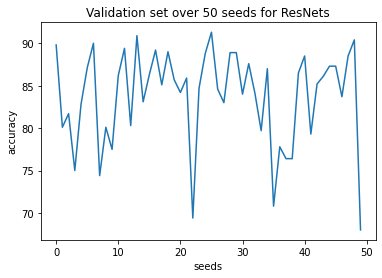

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accs_val)
plt.xlabel('seeds')
plt.ylabel('accuracy')
plt.title('Validation set over 50 seeds for ResNets');
plt.savefig('C1val50seeds_randAugment.png')